# CIS-522 Week 9: RNNs

__Instructor__: Lyle Ungar

__Content creators:__ Anushree Hede

* background: time series and memory
* How to handle time series: 1-D CNN + padding or recurrence 
* An aside: embeddings (words, but also documents, pictures, people, ….)
Word2vec?  Digit2vec 
* Recurrent Neural Net architecture and how to unroll and backpropagate through time
* RNN uses overview; the role of embeddings
** generation (predict next character or word)
** tagging (predict POS label from hidden state)
** seq2seq (in:“11 + 15” out:“26”>
* the curse of exponential forgetting
* GRUs and LSTMs address forgetting (somewhat)
* BiLSTMs
* Societal issues: NSFW/hate speech classification challenges
* the final project (watch on your own)



0. overview

1. Introduction to embeddings 
 
    a. Transition: one-hot vectors to Word2Vec  
    b. Word2Vec encodes similarity - try out a bunch of word similarities  
    c. plot these and see how words compare in the Word2Vec space  

2. RNN architecture   (using word embeddings)

    a. Rolling out, hidden states - how this is useful in time-series     
    b. Building an RNN in PyTorch  
    c. Solve a (movie review/tweet sentiment) problem with this   
    d. Compare against a baseline FFN to see difference in performance  
    e. Compare number of parameters in a system that uses one-hot vs embeddings   

3. LSTMs 

    a. Exploding and vanishing gradients  
    b. How LSTM works, architecture   
    c. Train LSTM on the same problem and see improvement  
    d. biLSTMs  - does it help?
    e. Forgetting. learn a simple problem: does this sequence of characters contain a “0”? Do this first with a standard RNN, then with an LSTM, with the “0” further and further back from the end of the sequence.

4. Applications of RNNs in different NLP problems  (character level) 

    a. Set up a simple dataset (all character level problems)   
    b. Importance of the "hidden state"   
    c. Token classification / POS tagging  (tagging a character as a vowel or consonant)  
    d. Generation  - Gutenberg (need to change)   
    e. Seq2seq - encoder and decoder (German to English)


---
## Time series with neural nets
Video

---
## Embeddings

**Moving away from one-hot encodings**

- Main reason: one-hot encodings cannot sufficently capture the notion of similarity between words; the cosine similarity between any two distinct one-hot encoding vectors = 0. 
- Then how do we represent words in a more meaningful way for a deep learning model?
- Word embeddings: introduction 
- Implementations used widely - Word2Vec, GLoVE, (more recently BERT)
- For this week, we will use Word2Vec for all our exercises
- Link a source to study the Word2Vec algorithm details 

**Exercise to visualize word embeddings**

- Take a simple corpus (sifficiently small)
- Tokenize it using NLTK (or huggingface)
- Use gensim's API to train a Word2Vec model with this corpus
- Reduce the vector space to two dimensions 
- Visualize the space, and note how similar words are close to one another. Are there dissimilar words that are close to each other or similar words that are not close to each other? Why might this be happening?  
- Use Word2Vec's pretrained embeddings (Wikipedia, Google News), and compute the cosine similarities of (some given pairs of words). Find your own pairs that give you high and low similarities. 
- This exercise is to convince the learners that such embeddings capture similarities an hold an important place when deep learning is applied to language applications. 
- (Need to think about discussion questions here).    

LHU: this overlaps with week 10. There will be a general video about embeddings; then  just do a simple word2vec; see comment  below  to make sure the demo actually works.

We will be using huggingface there. If it's easy, let's use it here,  too (steal the code from there). It will give better tokenization. just using a regex drops punctuation, among other problems.

In [ ]:
!pip install --upgrade gensim
from gensim.models import Word2Vec
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')
import numpy as np
from nltk.corpus import brown
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline
import re
from IPython.display import Image

     |████████████████████████████████| 24.2MB 135kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


In [ ]:
!pip show torchtext

Name: torchtext
Version: 0.3.1
Summary: Text utilities and datasets for PyTorch
Home-page: https://github.com/pytorch/text
Author: PyTorch core devs and James Bradbury
Author-email: jekbradbury@gmail.com
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, tqdm, torch, requests
Required-by: 


In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

# plt.rcParams.update(plt.rcParamsDefault)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

### Introduction

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, with each unique word in the corpus being assigned a corresponding vector in the space. 

### Creating Word Embeddings

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html).  In order to achieve this task we will use [gensim](https://radimrehurek.com/gensim/) library to create word2vec embeddings. Gensim’s word2vec expects a sequence of sentences as its input. Each sentence a list of words.
Calling Word2Vec(sentences, iter=1) will run two passes over the sentences iterator (or, in general iter+1 passes). The first pass collects words and their frequencies to build an internal dictionary tree structure. The second and subsequent passes train the neural model. 
Word2vec accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:

`model = Word2Vec(sentences, min_count=10)  # default value is 5`


A reasonable value for min_count is between 0-100, depending on the size of your dataset.

Another parameter is the size of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

`model = Word2Vec(sentences, size=200)  # default value is 100`


Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

`model = Word2Vec(sentences, workers=4) # default = 1 worker = no parallelization`

In [ ]:
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction'] # ['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']

In [ ]:
def create_word2vec_model(category = 'news', size = 50, sg = 1, min_count = 5):
  try:
    sentences = brown.sents(categories=brown.categories()) #(categories=category) #returns sentences as a list of tokens
    model = Word2Vec(sentences, size=size, sg=sg, min_count=min_count)

  except (AttributeError, TypeError):
      raise AssertionError('Input variable "category" should be a string or list,  "size", "sg", "min_count" should be integers')

  return model

def model_dictionary(model):
  words = list(w2vmodel.wv.vocab)
  return words 

def get_embedding(word, model):
  if word in w2vmodel.wv.vocab:
    return model.wv[word]
  else:
    return None

The cell will take 30-45 seconds to run.

In [ ]:
w2vmodel = create_word2vec_model(category)

You can list all the words for which embeddings are created i.e. the dictionary.

In [ ]:
print(model_dictionary(w2vmodel))

You can get the embedding vector for a word in the dictionary.

In [ ]:
print(get_embedding('weather', w2vmodel))

What do the embeddings mean? What do they represent?

### Visualizing Word Embeddings

We can now obtain the word embeddings for any word in the dictionary using word2vec. Let's visualize these embeddings to get an inuition of what these embeddings mean. The word embeddings obtained from word2vec model are in high dimensional space. We will use PCA to pick the 2 features that capture the most variance in the embeddings in order to represent them in a 2D space.


For each word in `keys`, we pick the top 10 similar words (using cosing similarity) and plot them.  

 What should be the arrangement of similar words?
 What should be arrangement of the key clusters with respect to each other?
 

In [ ]:
keys = ['election', 'magic', 'love', 'God', 'evidence', 'administration', 'governments']

In [ ]:
def get_cluster_embeddings(keys):
  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
      embeddings = []
      words = []
      if not word in w2vmodel.wv.vocab:
        print('The word ', word, 'is not in the dictionary')
        continue

      for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
          words.append(similar_word)
          embeddings.append(w2vmodel.wv[similar_word])
      embedding_clusters.append(embeddings)
      word_clusters.append(words)

  # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
  return embeddings_en_2d, word_clusters

In [ ]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc="lower left")
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
tsne_plot_similar_words('Similar words from Brown Corpus', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

Analyze the plot and answer the questions below - 


What does having higher similarity between two word embeddings mean?



Why are cluster centers close to some keys but farther from others?


---
##RNNs: the architecture

* Rolling out, hidden states - how this is useful in time-series
* Build an RNN in PyTorch
*  Solve a (movie review/tweet sentiment) problem using RNN with embeddings
* Compare against a baseline FFN to see difference in performance
* Compare number of parameters in a system that uses one-hot vs embeddings


### Introduction

Recurrent neural networks, or RNNs , are a family of neural networks for processing sequential data. Just as a convolutional network is specialized for processing a grid of values X such as an image, a recurrent neural network is specialized for processing a sequence of values. RNNs prove useful in many scenarios where other deep learning models are not effective.

* Not all problems can be converted into one with fixedlength inputs and outputs.


* The deep learning models we have seen so far pick samples randomly. This might not be the best strategy for a task of understanding meaning from a piece of text. Words in a text occur in a sequence and therefore cannot be permuted randomly to get the meaning. 

* What if we want to use deep learning to accomplish the task of getting the next item in a sequence. An example for this would be predicting stock prices, auto-complete. 

* It is also not always practical to create networks for data that involve long sequences.

A related idea is the use of convolution across a 1-D temporal sequence. This convolutional approach is the basis for time-delay neural networks. The convolution operation allows a network to share parameters across time but is shallow. The output of convolution is a sequence where each member of the output is a function of a small number of neighboring members of the input. The idea of parameter sharing manifests in the application of the same convolution kernel at each time step.Recurrent networks share parameters in a diﬀerent way. Each member of the output is a function of the previous members of the output. Each member of the output is produced using the same update rule applied to the previous outputs. This recurrent formulation results in the sharing of parameters through a verydeep computational graph.

### Working of a RNN

Working -  rolling out, rnn shares weights across each time step

In [ ]:
Image(url='https://blog.floydhub.com/content/images/2019/04/rnn-2.gif')

### RNN in Pytorch

torchtext text classification - 
https://pytorch.org/text/stable/datasets.html#text-classification

IMDB 25k test and train

In [ ]:
import os
import sys
import random
import torch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext.vocab import Vectors
from torchtext import datasets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
LABEL = data.LabelField(dtype=torch.float)

In [ ]:

def tokenize(x):
  x = x.split()
  for i in range(len(x)):
    x[i] = x[i].lower().replace('\n', '')
  return x

def load_dataset(test_sen=None):

    """
    tokenizer : Breaks sentences into a list of words. If sequential=False, no tokenization is applied
    Field : A class that stores information about the way of preprocessing
    fix_length : An important property of TorchText is that we can let the input to be variable length, and TorchText will
                 dynamically pad each sequence to the longest sequence in that "batch". But here we are using fix_length which
                 will pad each sequence to have a fix length of 200.
                 
    build_vocab : It will first make a vocabulary or dictionary mapping all the unique words present in the train_data to an
                  idx and then after it will use GloVe word embedding to map the index to the corresponding word embedding.
                  
    vocab.vectors : This returns a torch tensor of shape (vocab_size x embedding_dim) containing the pre-trained word embeddings.
    BucketIterator : Defines an iterator that batches examples of similar lengths together to minimize the amount of padding needed.
    
    """
    
    #tokenize = lambda x: x.split().lower().replace('\n', '')
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
    LABEL = data.LabelField(dtype=torch.float)
    train_data, test_data = datasets.AG_NEWS.splits(TEXT, LABEL)
    TEXT.build_vocab(train_data) #If no specific vector embeddings are specified, Torchtext initializes random vector embeddings which would get updated during training through backpropagation.
    LABEL.build_vocab(train_data)

    # word_embeddings = TEXT.vocab.vectors Ref - https://github.com/pytorch/text/issues/32
    #nn.embeddings will set the weights randomly
    # print("Word Embeddings: " + word_embeddings)
    print("Length of Text Vocabulary: " + str(len(TEXT.vocab)))
    print("Label Length: " + str(len(LABEL.vocab)))

    train_data, valid_data = train_data.split(split_ratio=0.7, random_state = random.seed(23))
    # train_data, valid_data = train_data.split() # Further splitting of training_data to create new training_data & validation_data
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=32, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

    '''Alternatively we can also use the default configurations'''
    # train_iter, test_iter = datasets.IMDB.iters(batch_size=32)

    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, train_iter, valid_iter, test_iter

In [ ]:
class RNN(nn.Module):
  def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length):
    super(RNN, self).__init__()

    self.batch_size = batch_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.dropout = nn.Dropout(0.5)
    self.rnn = nn.RNN(embedding_length, hidden_size, num_layers=2, bidirectional=True)
    self.label = nn.Linear(4*hidden_size, output_size)

  def forward(self, input_sentences, batch_size=None):
    input = self.word_embeddings(input_sentences)
    input = input.permute(1, 0, 2)
    h_0 =  Variable(torch.zeros(4, self.batch_size, self.hidden_size).cuda())
    input = self.dropout(input)
    output, h_n = self.rnn(input, h_0)
    print(output.shape, h_n.shape)
    h_n = h_n.permute(1, 0, 2) # h_n.size() = (batch_size, 4, hidden_size)
    h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])

    print(h_n)
    logits = self.label(h_n) # logits.size() = (batch_size, output_size)
    
    return logits

In [ ]:
# class RNN(nn.Module):
#   def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length):
#     super(RNN, self).__init__()

#     self.batch_size = batch_size
#     self.output_size = output_size
#     self.hidden_size = hidden_size
#     self.vocab_size = vocab_size
#     self.embedding_length = embedding_length

#     self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
#     self.dropout = nn.Dropout(0.5)
#     self.rnn = nn.RNN(embedding_length, hidden_size, num_layers=1, bidirectional=False)
#     self.label = nn.Linear(hidden_size, output_size)

#   def forward(self, input_sentences, batch_size=None):
#     input = self.word_embeddings(input_sentences)
#     print('input: ', input.shape)
#     input = input.permute(1, 0, 2)
#     h_0 =  Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) #automatic
#     input = self.dropout(input)
#     output, h_n = self.rnn(input, h_0)
#     print(output.shape, h_n.shape)
#     h_n = h_n.permute(1, 0, 2) # h_n.size() = (batch_size, 4, hidden_size)
#     h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    
#     print(h_n.shape)
#     logits = self.label(h_n) # logits.size() = (batch_size, output_size)
    
#     return logits

In [ ]:
def train_model(model, train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not 32):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
 
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        
        optim.step()
        steps += 1
        
        if steps % 100 == 0:
            print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)


In [ ]:
def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

In [ ]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset()
print(len(train_iter),  len(valid_iter), len(test_iter))

AttributeError: ignored

In [ ]:
learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 16
embedding_length = 100

training_loss, training_acc, validation_loss, validation_acc, epochs = [], [], [], [], []

model = RNN(batch_size, output_size, hidden_size, vocab_size, embedding_length)
loss_fn = F.cross_entropy

for epoch in range(10):
    train_loss, train_acc = train_model(model, train_iter, epoch)
    val_loss, val_acc = eval_model(model, valid_iter)
    training_loss.append(train_loss)
    training_acc.append(train_acc)
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    epochs.append(epoch)
    
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')
    
test_loss, test_acc = eval_model(model, test_iter)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

NameError: ignored

In [ ]:
plt.plot(epochs, training_acc, label='training_accuracy')
plt.plot(epochs, validation_acc, label='validation_accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.title('RNN on IMDB text classification')

In [ ]:
plt.plot(epochs, training_loss, label='training_loss')
plt.plot(epochs, validation_loss, label='validation_loss')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.title('RNN on IMDB text classification')

### RNN vs FNN

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        #batch_size, output_size, hidden_size, vocab_size, embedding_length
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer does not participate in training
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no weight, so it can share an
        # instance
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate the output of two embedding layers with shape of
        # (batch size, no. of words, word vector dimension) by word vector
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # According to the input format required by Conv1d, the word vector
        # dimension, that is, the channel dimension of the one-dimensional
        # convolutional layer, is transformed into the previous dimension
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor with the shape of (batch size, channel size, 1)
        # can be obtained. Use the flatten function to remove the last
        # dimension and then concatenate on the channel dimension
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        # After applying the dropout method, use a fully connected layer to
        # obtain the output
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [ ]:
def train_model1(model, train_iter, epoch, optim, loss_fn):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    # optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()

        optim.zero_grad()
        prediction = model(text)
        
        loss = loss_fn(prediction, target)

        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        
        optim.step()
        steps += 1
        
        if steps % 100 == 0:
            print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)


In [ ]:
def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

In [ ]:
# TEXT, vocab_size, train_iter, valid_iter, test_iter 
embedding_length = 100
kernel_sizes = [3, 4, 5]
nums_channels = [100, 100, 100]
net = TextCNN(vocab_size, embedding_length, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)


TextCNN(
  (embedding): Embedding(251639, 100)
  (constant_embedding): Embedding(251639, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [ ]:
learning_rate = 0.001
num_epochs = 5
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
# loss_function = F.cross_entropy
training_loss, training_acc, validation_loss, validation_acc, epochs = [], [], [], [], []

for epoch in range(num_epochs):
  train_loss, train_acc = train_model1(net, train_iter, epoch, optimizer, loss_function)
  val_loss, val_acc = eval_model(net, valid_iter)
  training_loss.append(train_loss)
  training_acc.append(train_acc)
  validation_loss.append(val_loss)
  validation_acc.append(val_acc)
  epochs.append(epoch)
  
  print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')
    
test_loss, test_acc = eval_model(model, test_iter)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')


Epoch: 1, Idx: 100, Training Loss: 0.4237, Training Accuracy:  81.25%
Epoch: 1, Idx: 200, Training Loss: 0.5407, Training Accuracy:  75.00%
Epoch: 1, Idx: 300, Training Loss: 0.3785, Training Accuracy:  75.00%
Epoch: 1, Idx: 400, Training Loss: 0.4453, Training Accuracy:  68.75%
Epoch: 1, Idx: 500, Training Loss: 0.4259, Training Accuracy:  84.38%
Epoch: 1, Train Loss: 0.396, Train Acc: 82.43%, Val. Loss: 0.388686, Val. Acc: 82.11%
Epoch: 2, Idx: 100, Training Loss: 0.1397, Training Accuracy:  96.88%
Epoch: 2, Idx: 200, Training Loss: 0.3062, Training Accuracy:  90.62%
Epoch: 2, Idx: 300, Training Loss: 0.2861, Training Accuracy:  84.38%
Epoch: 2, Idx: 400, Training Loss: 0.1986, Training Accuracy:  90.62%
Epoch: 2, Idx: 500, Training Loss: 0.1841, Training Accuracy:  90.62%
Epoch: 2, Train Loss: 0.258, Train Acc: 89.50%, Val. Loss: 0.382923, Val. Acc: 84.26%
Epoch: 3, Idx: 100, Training Loss: 0.1834, Training Accuracy:  90.62%
Epoch: 3, Idx: 200, Training Loss: 0.1332, Training Accura

Text(0.5, 1.0, 'CNN on IMDB text classification')

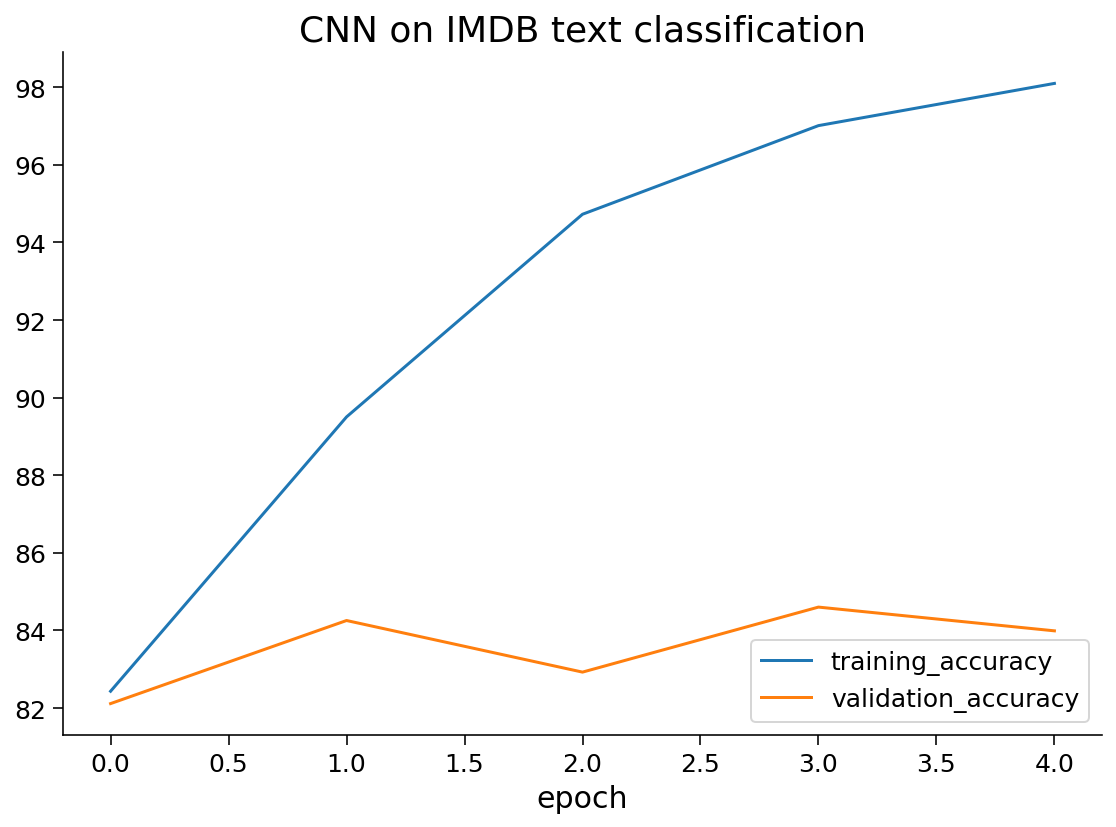

In [ ]:
plt.plot(epochs, training_acc, label='training_accuracy')
plt.plot(epochs, validation_acc, label='validation_accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.title('CNN on IMDB text classification')

Text(0.5, 1.0, 'CNN on IMDB text classification')

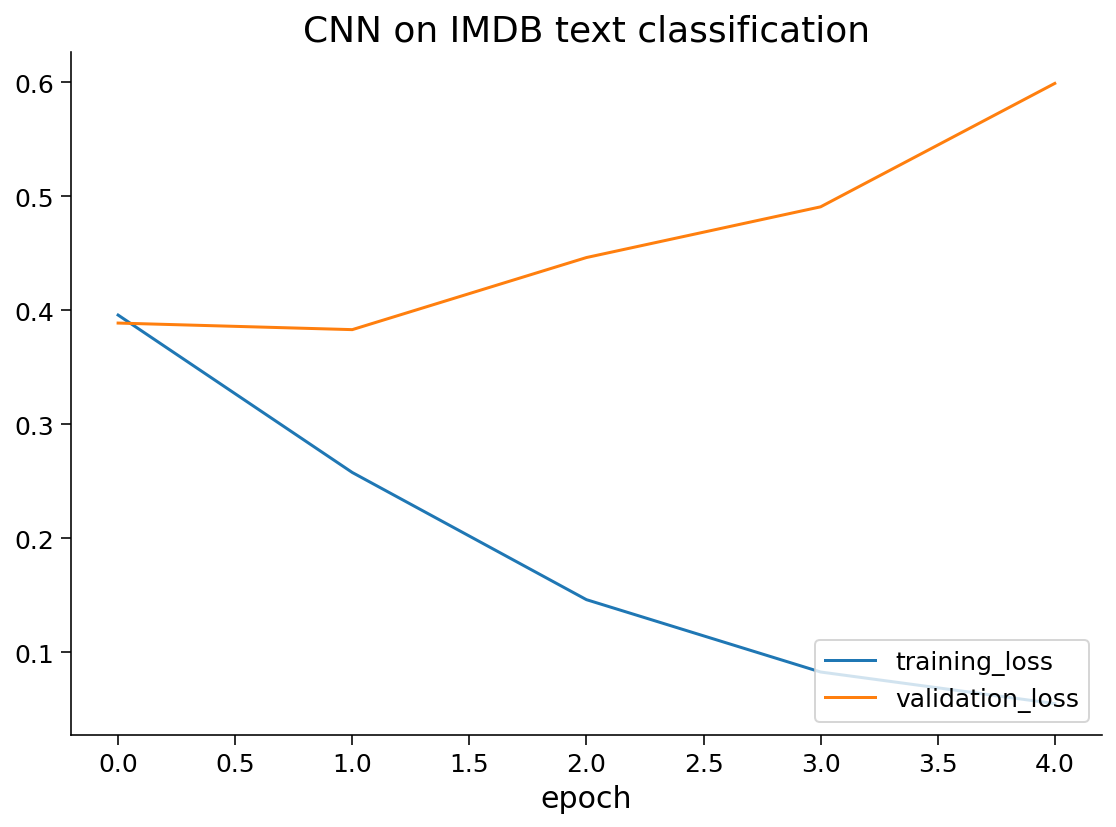

In [ ]:
plt.plot(epochs, training_loss, label='training_loss')
plt.plot(epochs, validation_loss, label='validation_loss')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.title('CNN on IMDB text classification')

### One Hot vs Embedding 

### Architectures 

Add some fun applications??/Ask what could be an application for each architecture

Speech to text: many to many - https://www.alienmaths.com/

Image caption - https://blog.google/products/search/get-more-useful-information-captions-google-images/

In [ ]:
Image(url='https://blog.floydhub.com/content/images/2019/04/karpathy.jpeg', width = 700)

### Disadvantages

Problems with RNNs:

* Vanishing gradients-
In a long sequence, the gradients get multiplied by the weight matrix (transpose) at every time step. If there are small values in the weight matrix, the norm of gradients get smaller and smaller exponentially.
* Exploding gradients-
If we have a large weight matrix and the non-linearity in the recurrent layer is not saturating, the gradients will explode. The weights will diverge at the update step. We may have to use a tiny learning rate for the gradient descent to work.
One reason to use RNNs is for the advantage of remembering information in the past. However, it could fail to memorize the information long ago in a simple RNN without tricks.

An example that has vanishing gradient problem:

The input is the characters from a C Program. The system will tell whether it is a syntactically correct program. A syntactically correct program should have a valid number of braces and parentheses. Thus, the network should remember how many open parentheses and braces there are to check, and whether we have closed them all. The network has to store such information in hidden states like a counter. However, because of vanishing gradients, it will fail to preserve such information in a long program.

#LSTMs

* Exploding and vanishing gradients
* How LSTMs work, architecture
* Train an LSTM on the same problem and see improvement
* biLSTMs - does it help? 
* Forgetting. learn a simple problem: does this sequence of characters contain a “0”? Do this first with a standard RNN, then with an LSTM, with the “0” further and further back from the end of the sequence.

# exploding and vanishing gradients in RNNs

# LSTM architecture and training

# biLSTMs

# Uses of RNNs in  NLP

video

# Generation

In [ ]:
! wget http://www.gutenberg.org/cache/epub/29765/pg29765.txt

In [ ]:
! pip install unidecode

In [ ]:
# YOUR CODE HERE
import unidecode
import string
import random
import re

# Get all printable characters for generation
all_characters = string.printable
n_characters = len(all_characters)

# Read the input training file - Webster dictionary
# file = unidecode.unidecode(open('shakespeare_input.txt').read())
file = unidecode.unidecode(open('pg29765.txt').read()) # Comment the other one
file_len = len(file)
print('file_len =', file_len)

In [ ]:
# Print a random chunk from the training data 
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

chunk_len = 200
print(random_chunk(chunk_len))

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# Define our RNN for character generation
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1)) # What is the size of the input
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF')) # Indices of the chars in our character list

In [ ]:
# Get a random chunk from the traning data, 
# Convert its first n-1 chars into input char tensor
# Convert its last n-1 chars into target char tensor
def random_training_set():    
    chunk = random_chunk(chunk_len)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [ ]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
# Single training step
def train(inp, target):
    # Initialize hidden state, zero the gradients of decoder 
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    # For each character in our chunk (except last), compute the hidden and ouput
    # Using each output, compute the loss with the corresponding target 
    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    # Backpropagate and optimize
    loss.backward()
    decoder_optimizer.step()

    # Return average loss
    return loss.data.item() / chunk_len

In [ ]:
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

# Create model, optimizer and loss function
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

# For every epoch
for epoch in range(1, n_epochs + 1):
    # Get a random (input, target) pair from training set and perform one training iteration
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        text = evaluate('Wh', 100)
        print('Predicted: ', text)
        
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

In [ ]:
torch.save(decoder.state_dict(), 'myGenerationModel.pt')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Tagging

# Seq2Seq 

\< Working on the Machine Translation task. Source: . Converting it to a character level task (and will try to have Pig-Latin \>

In [ ]:
!pip install d2l

     |████████████████████████████████| 81kB 9.1MB/s 


In [ ]:
from d2l import torch as d2l
import os
import torch
import math
import collections
import random

### Preprocessing

In [ ]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')
data_dir = d2l.download_extract('fra-eng')
with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
    raw_text = f.read()

In [ ]:
#@save
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)
    # return text

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## Tokenization


In [ ]:
#@save
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    source_char_set = set()
    target_char_set = set()
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            src_txt, tgt_txt = parts
            cur_src, cur_tgt = [], []
            for c in src_txt:
                cur_src.append(c)
                source_char_set.add(c)
            for c in tgt_txt:
                cur_tgt.append(c)
                target_char_set.add(c)
            source.append(cur_src)
            target.append(cur_tgt)

    special_tokens = ['<eos>', '<bos>', '<pad>']
    for tok in special_tokens:
        source_char_set.add(tok)
        target_char_set.add(tok)    
    return source, target, sorted(list(source_char_set)), sorted(list(target_char_set)) 

source, target, source_vocab, target_vocab = tokenize_nmt(text)
source_idx2token = dict((i, char) for i, char in enumerate(source_vocab))
target_idx2token = dict((i, char) for i, char in enumerate(target_vocab))
source_vocab = dict((char, i) for i, char in enumerate(source_vocab))
target_vocab = dict((char, i) for i, char in enumerate(target_vocab))
print(len(source), len(target))
source[:6], target[:6]

167130 167130


([['g', 'o', ' ', '.'],
  ['h', 'i', ' ', '.'],
  ['r', 'u', 'n', ' ', '!'],
  ['r', 'u', 'n', ' ', '!'],
  ['w', 'h', 'o', ' ', '?'],
  ['w', 'o', 'w', ' ', '!']],
 [['v', 'a', ' ', '!'],
  ['s', 'a', 'l', 'u', 't', ' ', '!'],
  ['c', 'o', 'u', 'r', 's', ' ', '!'],
  ['c', 'o', 'u', 'r', 'e', 'z', ' ', '!'],
  ['q', 'u', 'i', ' ', '?'],
  ['ç', 'a', ' ', 'a', 'l', 'o', 'r', 's', ' ', '!']])

In [ ]:
# Can remove later
data = list(zip(source, target))
source_sample=[]
target_sample=[]
for a,b in random.sample(data, 10000):
    source_sample.append(a)
    target_sample.append(b)
source = source_sample
target = target_sample

NUM_STEPS = 100
# NUM_STEPS = max(max([len(s) for s in source]), max([len(t) for t in target]))

## Vocabulary

Since the machine translation dataset
consists of pairs of languages,
we can build two vocabularies for
both the source language and
the target language separately.
With word-level tokenization,
the vocabulary size will be significantly larger
than that using character-level tokenization.
To alleviate this,
here we treat infrequent tokens
that appear less than 2 times
as the same unknown ("&lt;unk&gt;") token.
Besides that,
we specify additional special tokens
such as for padding ("&lt;pad&gt;") sequences to the same length in minibatches,
and for marking the beginning ("&lt;bos&gt;") or end ("&lt;eos&gt;") of sequences.
Such special tokens are commonly used in
natural language processing tasks.


In [ ]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

input = [source_vocab[c] for c in source[0]]
print(input)
truncate_pad(input, 10, source_vocab['<pad>'])

[36, 0, 29, 39, 28, 40, 32, 0, 47, 42, 40, 0, 33, 42, 45, 0, 50, 35, 28, 47, 0, 35, 28, 43, 43, 32, 41, 32, 31, 0, 47, 42, 0, 28, 39, 39, 0, 42, 33, 0, 48, 46, 0, 10]


[36, 0, 29, 39, 28, 40, 32, 0, 47, 42]

In [ ]:
#@save
def build_array_nmt(data, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    complete_data, lengths = [], []
    for lines in data:
        lines = [vocab[l] for l in lines]
        lines.append(vocab['<eos>'])
        array = torch.tensor(truncate_pad(lines, num_steps, vocab['<pad>']))
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(0)
        complete_data.append(array)
        lengths.append(valid_len.item())
    return torch.stack(complete_data), torch.tensor(lengths)

In [ ]:
class MTDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, source, target):
        'Initialization'
        source_data, source_lens = build_array_nmt(source, source_vocab, NUM_STEPS)        
        target_data, target_lens = build_array_nmt(target, target_vocab, NUM_STEPS)
        self.source = source_data
        self.source_len = source_lens
        self.target = target_data
        self.target_len = target_lens

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.source)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.source[index], self.source_len[index], self.target[index], self.target_len[index]

In [ ]:
# Data loaders
dataset = MTDataset(source, target)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

In [ ]:
# #@save
# def load_data_nmt(batch_size, num_steps, num_examples=600):
#     """Return the iterator and the vocabularies of the translation dataset."""
#     text = preprocess_nmt(read_data_nmt())
#     source, target = tokenize_nmt(text, num_examples)
#     src_vocab = d2l.Vocab(source, min_freq=2,
#                           reserved_tokens=['<pad>', '<bos>', '<eos>'])
#     tgt_vocab = d2l.Vocab(target, min_freq=2,
#                           reserved_tokens=['<pad>', '<bos>', '<eos>'])
#     src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
#     tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
#     data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
#     data_iter = d2l.load_array(data_arrays, batch_size)
#     return data_iter, src_vocab, tgt_vocab

### Encoder

In [ ]:
from torch import nn

#@save
class Encoder(nn.Module):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super(Encoder, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [ ]:
encoder = Encoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

### Decoder

In [ ]:
#@save
class Decoder(nn.Module):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [ ]:
decoder = Decoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

### Putting it together

In [ ]:
#@save
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X):
        enc_outputs = self.encoder(enc_X)
        dec_state = self.decoder.init_state(enc_outputs)
        return self.decoder(dec_X, dec_state)

In [ ]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [ ]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [ ]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

### Training

In [ ]:
#@save
def train_seq2seq(net, data_loader, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        # TODO: without d2l?
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in dataloader:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            # print(bos.shape)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            # TOOD: Clip gradients without d2l
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)

            # break
        # break
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.013, 127296.4 tokens/sec on cuda


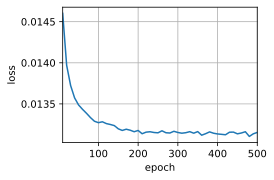

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 256, 2, 0.1
# batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 500, torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Encoder(
    len(source_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Decoder(
    len(target_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, dataloader, lr, num_epochs, target_vocab, device)

In [ ]:
#@save
def predict_seq2seq(net, src_sentence, device):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = [source_vocab[c] for c in src_sentence.lower()] + [source_vocab['<eos>']]
    # enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, NUM_STEPS, source_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X)
    dec_state = net.decoder.init_state(enc_outputs)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor([target_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(NUM_STEPS):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == target_vocab['<eos>']:
            break
        output_seq.append(pred)
    return output_seq

In [ ]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation = predict_seq2seq(net, eng, device)
    translation = ''.join([target_idx2token[i] for i in translation])
    print('English: %s ; French: %s ; Tranlation: %s' % (eng, fra, translation))
    # print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

English: go . ; French: va ! ; Tranlation: voirte de treut plent de te plent de temps .
English: i lost . ; French: j'ai perdu . ; Tranlation: j'ai de trarn de trarns .
English: he's calm . ; French: il est calme . ; Tranlation: il que de ples de te plent de te fait de te plent de te plent de tempstorrre .
English: i'm home . ; French: je suis chez moi . ; Tranlation: je s de te protrrert .


# Societal issues: NSF/hate speech classification challenges




# the final project 

Video (watch on your own) and link to  description

---
# Wrap up


In [ ]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

import time
import numpy as np
from IPython.display import IFrame

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()
try: t6;
except NameError: t6 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""

try: my_pod;
except NameError: my_pod = ""

try: learning_from_previous_week;
except NameError: learning_from_previous_week = "" 
